# 프로젝트 : mini BERT 만들기
- vocab size: 8000
- 전체 파라미터 : 1M
- epoch : 10

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import os
import re
import math
import numpy as np
import pandas as pd
import random
import collections
import json
import shutil
import zipfile
import copy
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
import sentencepiece as spm
from tqdm.notebook import tqdm

In [2]:
# 재현성을 위한 Random seed 설정
random_seed = 1234
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(random_seed)

print("Torch 버전:", torch.__version__)

Torch 버전: 2.7.1+cu118


## 1. 토크나이저(Tokenizer) 준비
- SentencePiece 모델을 이용해 BERT의 MLM 학습용 데이터를 만듭니다.
- 한글 나무 위키 코퍼스(`kowiki.txt`)로부터 8000의 vocab_size를 갖는 sentencepiece 모델을 만듭니다.
- BERT에 사용되는 주요 특수문자가 vocab에 포함되도록 합니다: `[PAD], [UNK], [BOS], [EOS], [SEP], [CLS], [MASK]`

In [3]:
pwd

'/home/jovyan/work/bert_pretrain'

In [4]:
corpus_file = 'data/kowiki.txt'
prefix = 'ko_8000'
vocab_size = 8000

if not os.path.exists(f'{prefix}.model'):
    spm.SentencePieceTrainer.train(
        f"--input={corpus_file} --model_prefix={prefix} --vocab_size={vocab_size + 7}"
        f" --model_type=bpe --max_sentence_length=999999 --pad_id=0 --pad_piece=[PAD]"
        f" --unk_id=1 --unk_piece=[UNK] --bos_id=2 --bos_piece=[BOS] --eos_id=3"
        f" --eos_piece=[EOS] --user_defined_symbols=[SEP],[CLS],[MASK]"
    )

vocab = spm.SentencePieceProcessor()
vocab.load(f"{prefix}.model")

vocab_list = []
for i in range(7, len(vocab)):
    if not vocab.is_unknown(i):
        vocab_list.append(vocab.id_to_piece(i))

## 2. 데이터 전처리 (1) MASK 생성
- BERT의 MLM(Masked Language Model)에 필요한 빈칸(mask)을 생성하는 함수를 정의합니다.
- 학습 데이터 전체 토큰의 15%를 마스킹합니다.
- 마스킹 전략: 80%는 `[MASK]` 토큰으로, 10%는 랜덤 토큰으로, 10%는 원래 토큰을 그대로 사용합니다.

In [5]:
def create_pretrain_mask(tokens, mask_cnt, vocab_list):
    """
    Pre-training을 위한 마스크를 생성하는 함수
    :param tokens: 토큰 리스트
    :param mask_cnt: 마스킹할 토큰 개수 (전체의 15%)
    :param vocab_list: 랜덤 토큰 대체를 위한 어휘 리스트
    :return tokens: 마스크가 적용된 토큰
    :return mask_idx: 마스킹된 토큰의 인덱스
    :return mask_label: 마스킹된 토큰의 원래 값
    """
    # 1. Whole-word-masking을 위해 토큰을 단어 단위로 분할
    cand_idx = []
    for (i, token) in enumerate(tokens):
        if token in ["[CLS]", "[SEP]"]:
            continue
        # u"\u2581"는 단어의 시작을 의미
        if token.startswith(u"\u2581"):
            cand_idx.append([i])
        else:
            if cand_idx:
                cand_idx[-1].append(i)

    # 2. 랜덤 마스킹을 위해 단어 순서를 섞음
    random.shuffle(cand_idx)

    mask_lms = []
    for index_set in cand_idx:
        if len(mask_lms) >= mask_cnt:
            break
        # 현재 단어를 추가하면 mask_cnt를 초과할 경우 건너뜀
        if len(mask_lms) + len(index_set) > mask_cnt:
            continue
        
        # 80%는 [MASK], 10%는 랜덤 단어, 10%는 원본 유지
        dice = random.random()
        for index in index_set:
            masked_token = None
            if dice < 0.8:
                masked_token = "[MASK]"
            elif dice < 0.9:
                masked_token = tokens[index]
            else:
                masked_token = random.choice(vocab_list)
            
            mask_lms.append({"index": index, "label": tokens[index]})
            tokens[index] = masked_token

    # 3. 인덱스 순으로 정렬 후 mask_idx와 mask_label 추출
    mask_lms = sorted(mask_lms, key=lambda x: x["index"])
    mask_idx = [p["index"] for p in mask_lms]
    mask_label = [p["label"] for p in mask_lms]

    return tokens, mask_idx, mask_label

## 3. 데이터 전처리 (2) NSP pair 생성
- BERT의 pretrain 과제인 NSP(Next Sentence Prediction)를 위한 데이터 쌍을 생성하는 함수를 정의합니다.
- 50%의 확률로 실제 이어지는 문장(is_next=1)과 랜덤으로 추출된 문장(is_next=0)을 쌍으로 만듭니다.
- 문장 구분을 위해 세그먼트 임베딩 값(0 또는 1)을 부여합니다.

In [6]:
def trim_tokens(tokens_a, tokens_b, max_seq):
    """ 두 시퀀스의 길이가 최대 길이를 넘지 않도록 자르는 함수 """
    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_seq:
            break
        if len(tokens_a) > len(tokens_b):
            tokens_a.pop()
        else:
            tokens_b.pop()

def create_pretrain_instances(vocab, doc, n_seq, mask_prob, vocab_list):
    """ 한 문서(document)에서 pre-training 인스턴스를 생성하는 함수 """
    # [CLS], [SEP], [SEP] 토큰 3개를 고려하여 최대 길이를 n_seq - 3으로 설정
    max_seq = n_seq - 3

    instances = []
    current_chunk = []
    current_length = 0
    for i in range(len(doc)):
        current_chunk.append(doc[i])
        current_length += len(doc[i])
        
        if i == len(doc) - 1 or current_length >= max_seq:
            if current_chunk:
                a_end = 1
                if len(current_chunk) > 1:
                    a_end = random.randrange(1, len(current_chunk))
                
                tokens_a = []
                for j in range(a_end):
                    tokens_a.extend(current_chunk[j])
                
                tokens_b = []
                is_next = 1 # 기본값: 실제 이어지는 문장 (IsNext)
                if len(current_chunk) > 1 and random.random() < 0.5:
                    is_next = 0 # 50% 확률로 이어지지 않는 문장 (NotNext)
                    # 이 경우, 다른 문서에서 tokens_b를 가져와야 하지만, 
                    # 이 코드에서는 간단하게 A와 B를 바꾸는 방식으로 구현
                    temp = tokens_a
                    tokens_a = tokens_b
                    tokens_b = temp
                
                for j in range(a_end, len(current_chunk)):
                    tokens_b.extend(current_chunk[j])
                
                trim_tokens(tokens_a, tokens_b, max_seq)
                if not tokens_a or not tokens_b:
                    continue

                # 최종 토큰 및 세그먼트 ID 구성
                tokens = ["[CLS]"] + tokens_a + ["[SEP]"] + tokens_b + ["[SEP]"]
                segment = [0] * (len(tokens_a) + 2) + [1] * (len(tokens_b) + 1)
                
                # 마스킹 적용
                mask_cnt = int((len(tokens) - 3) * mask_prob)
                tokens, mask_idx, mask_label = create_pretrain_mask(tokens, mask_cnt, vocab_list)

                instance = {
                    "tokens": tokens,
                    "segment": segment,
                    "is_next": is_next,
                    "mask_idx": mask_idx,
                    "mask_label": mask_label
                }
                instances.append(instance)

            current_chunk = []
            current_length = 0
            
    return instances

## 4. 데이터 전처리 (3) 데이터셋 완성
- 위에서 정의한 함수들을 사용해 전체 `kowiki.txt` 코퍼스를 BERT pretrain 데이터셋으로 변환합니다.
- 생성된 데이터는 json 포맷으로 저장합니다.
- 대용량 데이터를 효율적으로 다루기 위해 `np.memmap`을 사용하여 데이터를 로드하는 함수를 정의합니다.

In [7]:
def make_pretrain_data(vocab, in_file, out_file, n_seq, mask_prob=0.15):
    """ Pre-training 데이터를 생성하여 파일로 저장하는 함수 """
    
    vocab_list = [vocab.id_to_piece(i) for i in range(7, len(vocab)) if not vocab.is_unknown(i)]
    
    line_cnt = 0
    with open(in_file, "r") as f:
        for _ in f:
            line_cnt += 1

    with open(in_file, "r") as in_f, open(out_file, "w") as out_f:
        doc = []
        for line in tqdm(in_f, total=line_cnt, desc="데이터 생성 중"):
            line = line.strip()
            if not line: # 빈 줄이면 문단(doc) 처리
                if doc:
                    instances = create_pretrain_instances(vocab, doc, n_seq, mask_prob, vocab_list)
                    for instance in instances:
                        out_f.write(json.dumps(instance, ensure_ascii=False))
                        out_f.write("\n")
                    doc = []
            else:
                pieces = vocab.encode_as_pieces(line)
                if pieces:
                    doc.append(pieces)
        
        if doc: # 파일 끝에 남은 doc 처리
            instances = create_pretrain_instances(vocab, doc, n_seq, mask_prob, vocab_list)
            for instance in instances:
                out_f.write(json.dumps(instance, ensure_ascii=False))
                out_f.write("\n")

In [8]:
pretrain_json_path = 'bert_pre_train.json'
n_seq = 128 # 시퀀스 길이

if not os.path.exists(pretrain_json_path):
    print("Pre-training 데이터가 없습니다. 새로 생성합니다...")
    make_pretrain_data(vocab, corpus_file, pretrain_json_path, n_seq)
    print("데이터 생성이 완료되었습니다.")
else:
    print("Pre-training 데이터가 이미 존재하여 생성을 건너뜁니다.")

def load_pre_train_data(vocab, filename, n_seq, count=None):
    """
    메모리 매핑(memory-mapped) numpy 배열로 pre-training 데이터를 로드하는 함수
    """
    line_total = 0
    with open(filename, "r") as f:
        for _ in f:
            line_total += 1

    total = count if count is not None and count < line_total else line_total
    
    # np.memmap을 사용하여 메모리를 효율적으로 사용
    enc_tokens = np.memmap(filename='enc_tokens.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))
    segments = np.memmap(filename='segments.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))
    labels_nsp = np.memmap(filename='labels_nsp.memmap', mode='w+', dtype=np.int32, shape=(total,))
    labels_mlm = np.memmap(filename='labels_mlm.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))

    with open(filename, "r") as f:
        for i, line in enumerate(tqdm(f, total=total, desc="데이터 로딩 중")):
            if i >= total:
                break
            data = json.loads(line)
            
            # 인코더 입력
            enc_token = [vocab.piece_to_id(p) for p in data["tokens"]]
            enc_token += [0] * (n_seq - len(enc_token))
            
            # 세그먼트 입력
            segment = data["segment"]
            segment += [0] * (n_seq - len(segment))

            # NSP 레이블
            label_nsp = data["is_next"]

            # MLM 레이블
            mask_idx = np.array(data["mask_idx"], dtype=np.int32)
            mask_label = np.array([vocab.piece_to_id(p) for p in data["mask_label"]], dtype=np.int32)
            label_mlm = np.full(n_seq, dtype=np.int32, fill_value=0)
            if mask_idx.size > 0:
                label_mlm[mask_idx] = mask_label

            enc_tokens[i] = enc_token
            segments[i] = segment
            labels_nsp[i] = label_nsp
            labels_mlm[i] = label_mlm

    return (enc_tokens, segments), (labels_nsp, labels_mlm)

Pre-training 데이터가 이미 존재하여 생성을 건너뜁니다.


In [9]:
pre_train_inputs, pre_train_labels = load_pre_train_data(vocab, pretrain_json_path, n_seq, count=128000)

데이터 로딩 중:   0%|          | 0/128000 [00:00<?, ?it/s]

In [10]:
# 처음과 마지막 확인
pre_train_inputs[0][0], pre_train_inputs[0][-1], pre_train_inputs[1][0], pre_train_inputs[1][-1], pre_train_labels[0][0], pre_train_labels[0][-1], pre_train_labels[1][0], pre_train_labels[1][-1]

(memmap([   5,    1,    1, 3324, 1042,  104, 3610, 3686, 3718,    1,    1,
          416,    1, 3625,  160, 3662,    7, 3629,  203,  241, 3602,    1,
          788,  243,    1,  796,  663, 1648,    1, 3625,    6,    6,    6,
            6,    6,    6,    4,    1,  207,    1,    1, 3646,  630, 3714,
            1,  429,    1, 3626,    1,    6,    6,    1,    1,    1,    1,
         3599,   13,   81,    1, 2247,    1, 3873,    1, 3813, 3873, 4196,
         3636,    1,    1, 1233,    1, 3599,    1, 3625,  243, 2780,   14,
         1510,    1,  414,  166,    6,    6,    6,    6,    6,  593,   21,
         5007,    6,    1,  813,   17, 3599,  307,    1,  104, 4313, 4290,
            1, 3718,   99, 3878,    1, 2543,  309,  337,    1, 3616, 3603,
            1, 3599,    6,    6,    1,    6,    1, 2378,    1,    1, 3293,
           13,    1, 2386, 2163, 3596, 3671,    4], dtype=int32),
 memmap([   5, 2191, 3599,    1,   81, 3604,  342, 2674, 3625,  294,    1,
            6,    1, 2540, 3600,  

## 5. BERT 모델 구현
- `pad mask`, `GELU` 활성화 함수 등 BERT 모델에 필요한 구성 요소들을 정의합니다.
- `SharedEmbedding`, `MultiHeadAttention`, `PositionWiseFeedForward`, `EncoderLayer` 등 Transformer의 핵심 레이어를 클래스로 구현합니다.
- 최종적으로 이들을 조합하여 pretrain을 위한 BERT 모델을 완성합니다.

In [11]:
def get_pad_mask(tokens, i_pad=0):
    mask = (tokens == i_pad).float()
    return mask.unsqueeze(1).expand(-1, tokens.size(1), -1)

# GELU 함수 직접 정의
def gelu(x):
    return 0.5 * x * (1 + torch.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * torch.pow(x, 3))))

class Config(dict):
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

class SharedEmbedding(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.shared_weights = nn.Parameter(torch.Tensor(config.n_vocab, config.d_model))
        nn.init.trunc_normal_(self.shared_weights, std=0.02)
    def forward(self, inputs, mode="embedding"):
        if mode == "embedding": return F.embedding(inputs, self.shared_weights)
        elif mode == "linear": return F.linear(inputs, self.shared_weights)

class PositionEmbedding(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.embedding = nn.Embedding(config.n_seq, config.d_model)
        nn.init.trunc_normal_(self.embedding.weight, std=0.02)
    def forward(self, inputs):
        position = torch.arange(inputs.size(1), device=inputs.device).unsqueeze(0)
        return self.embedding(position)

class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.W_Q = nn.Linear(config.d_model, config.n_head * config.d_head)
        self.W_K = nn.Linear(config.d_model, config.n_head * config.d_head)
        self.W_V = nn.Linear(config.d_model, config.n_head * config.d_head)
        self.W_O = nn.Linear(config.n_head * config.d_head, config.d_model)
    def forward(self, Q, K, V, attn_mask):
        batch_size = Q.size(0)
        q_s = self.W_Q(Q).view(batch_size, -1, self.config.n_head, self.config.d_head).transpose(1, 2)
        k_s = self.W_K(K).view(batch_size, -1, self.config.n_head, self.config.d_head).transpose(1, 2)
        v_s = self.W_V(V).view(batch_size, -1, self.config.n_head, self.config.d_head).transpose(1, 2)
        attn_mask = attn_mask.unsqueeze(1).repeat(1, self.config.n_head, 1, 1)
        scores = torch.matmul(q_s, k_s.transpose(-1, -2)) / np.sqrt(self.config.d_head)
        scores.masked_fill_(attn_mask.bool(), -1e9)
        attn_prob = nn.Softmax(dim=-1)(scores)
        context = torch.matmul(attn_prob, v_s)
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.config.n_head * self.config.d_head)
        output = self.W_O(context)
        return output, attn_prob

class PositionWiseFeedForward(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.W_1 = nn.Linear(config.d_model, config.d_ff)
        self.W_2 = nn.Linear(config.d_ff, config.d_model)
    def forward(self, inputs):
        return self.W_2(gelu(self.W_1(inputs)))

class EncoderLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.self_attention = MultiHeadAttention(config)
        self.norm1 = nn.LayerNorm(config.d_model, eps=config.layernorm_epsilon)
        self.ffn = PositionWiseFeedForward(config)
        self.norm2 = nn.LayerNorm(config.d_model, eps=config.layernorm_epsilon)
        self.dropout = nn.Dropout(config.dropout)
    def forward(self, enc_embed, self_mask):
        attn_out, attn_prob = self.self_attention(enc_embed, enc_embed, enc_embed, self_mask)
        norm1_out = self.norm1(enc_embed + self.dropout(attn_out))
        ffn_out = self.ffn(norm1_out)
        enc_out = self.norm2(norm1_out + self.dropout(ffn_out))
        return enc_out, attn_prob

class BERT(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.embedding = SharedEmbedding(config)
        self.position = PositionEmbedding(config)
        self.segment = nn.Embedding(2, config.d_model)
        self.norm = nn.LayerNorm(config.d_model, eps=config.layernorm_epsilon)
        self.dropout = nn.Dropout(config.dropout)
        self.encoder_layers = nn.ModuleList([EncoderLayer(config) for _ in range(config.n_layer)])
    def forward(self, enc_tokens, segments):
        enc_self_mask = get_pad_mask(enc_tokens, self.config.i_pad)
        embed = self.embedding(enc_tokens) + self.position(enc_tokens) + self.segment(segments)
        embed = self.norm(embed)
        enc_out = self.dropout(embed)
        attn_probs = []
        for layer in self.encoder_layers:
            enc_out, attn_prob = layer(enc_out, enc_self_mask)
            attn_probs.append(attn_prob)
        return enc_out, attn_probs

class PreTrainModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.bert = BERT(config)
        self.nsp_classifier = nn.Linear(config.d_model, 2)
        self.mlm_output = self.bert.embedding
    def forward(self, enc_tokens, segments):
        enc_tokens = enc_tokens.long()
        segments = segments.long()
        bert_out, attn_probs = self.bert(enc_tokens, segments)
        logits_cls = self.nsp_classifier(bert_out[:, 0, :])
        logits_lm = self.mlm_output(bert_out, mode="linear")
        return logits_cls, logits_lm, attn_probs

### Mini BERT 모델 하이퍼파라미터 설정
- 프로젝트 요구사항에 맞춰 `vocab_size=8000`, 전체 파라미터 약 1M가 되도록 `Config`를 설정합니다.
- `d_model=256`, `n_layer=2`, `d_ff=1024` 등으로 설정하여 약 120만 개의 파라미터를 갖는 모델을 구성했습니다.

In [12]:
# 훈련된 토크나이저의 실제 어휘 수를 가져옵니다.
actual_vocab_size = vocab.get_piece_size() 
print(f"실제 어휘 수: {actual_vocab_size}") # 8007이 출력되어야 합니다.

실제 어휘 수: 8007


In [13]:
# 모델 설정 (Config)
actual_vocab_size = vocab.get_piece_size()
config = Config({
    "d_model": 96,
    "n_layer": 2,
    "n_head": 4,
    "d_head": 24,
    "dropout": 0.1,
    "d_ff": 384,
    "layernorm_epsilon": 1e-12,
    "n_seq": n_seq,
    "n_vocab": actual_vocab_size,
    "i_pad": 0
})
model = PreTrainModel(config)
print(f"모델의 학습 가능한 파라미터 수: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

모델의 학습 가능한 파라미터 수: 1,005,218


## 6. pretrain 진행
- 코사인 러닝레이트 스케줄러(`CosineSchedule`)를 구현합니다.
- 10 Epoch 동안 모델 학습을 진행하고, 매 에포크마다 NSP와 MLM의 loss 및 accuracy를 기록합니다.
- 학습이 완료된 모델은 epoch별로 저장됩니다.

In [19]:
epochs = 10
batch_size = 64

# 장치 설정 (GPU 우선 사용)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"사용 장치: {device}")
model.to(device)

# DataLoader 준비
train_dataset = TensorDataset(
    torch.from_numpy(pre_train_inputs[0]),
    torch.from_numpy(pre_train_inputs[1]),
    torch.from_numpy(pre_train_labels[0]),
    torch.from_numpy(pre_train_labels[1])
)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# 옵티마이저, 손실 함수, 스케줄러 설정
optimizer = optim.Adam(model.parameters(), lr=1e-4)
loss_fn_nsp = nn.CrossEntropyLoss()
loss_fn_mlm = nn.CrossEntropyLoss(ignore_index=config.i_pad)

사용 장치: cuda


In [22]:
# CosineSchedule 클래스 정의
class CosineSchedule:
    def __init__(self, optimizer, train_steps, warmup_steps, max_lr):
        self.optimizer, self.train_steps, self.warmup_steps, self.max_lr = optimizer, train_steps, warmup_steps, max_lr
        self.step_num = 0
    def get_lr(self):
        if self.step_num < self.warmup_steps: return self.max_lr * self.step_num / self.warmup_steps
        else:
            progress = (self.step_num - self.warmup_steps) / (self.train_steps - self.warmup_steps)
            return self.max_lr * 0.5 * (1 + math.cos(math.pi * progress))
    def step(self):
        self.step_num += 1
        lr = self.get_lr()
        for param_group in self.optimizer.param_groups: param_group['lr'] = lr

train_steps = len(train_dataloader) * epochs
warmup_steps = train_steps // 10
scheduler = CosineSchedule(optimizer, train_steps, warmup_steps, max_lr=1e-4)

In [21]:
history = collections.defaultdict(list)
for epoch in range(epochs):
    model.train()
    
    total_nsp_loss, total_mlm_loss = 0, 0
    total_nsp_correct, total_mlm_correct = 0, 0
    total_nsp_count, total_mlm_count = 0, 0
    
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs}")
    for batch in progress_bar:
        enc_tokens_b, segments_b, labels_nsp_b, labels_mlm_b = [b.to(device) for b in batch]
        
        optimizer.zero_grad()
        scheduler.step()
        
        # 모델 forward pass 수정: 반환값을 3개로 받음
        logits_nsp, logits_mlm, _ = model(enc_tokens_b, segments_b)

        # 손실 계산
        loss_nsp = loss_fn_nsp(logits_nsp, labels_nsp_b.long())
        loss_mlm = loss_fn_mlm(logits_mlm.view(-1, config.n_vocab), labels_mlm_b.view(-1).long())
        total_loss = loss_nsp + loss_mlm
        
        total_loss.backward()
        optimizer.step()
        
        # 통계 업데이트
        total_nsp_loss += loss_nsp.item()
        total_mlm_loss += loss_mlm.item()
        
        # 정확도 계산
        nsp_preds = logits_nsp.argmax(dim=-1)
        total_nsp_correct += (nsp_preds == labels_nsp_b).sum().item()
        total_nsp_count += labels_nsp_b.size(0)
        
        mlm_preds = logits_mlm.argmax(dim=-1)
        mlm_mask = (labels_mlm_b != config.i_pad)
        total_mlm_correct += ((mlm_preds == labels_mlm_b) & mlm_mask).sum().item()
        total_mlm_count += mlm_mask.sum().item()
        
        progress_bar.set_postfix({
            'lr': f'{optimizer.param_groups[0]["lr"]:.2e}',
            'nsp_loss': f'{total_nsp_loss / (progress_bar.n + 1):.4f}',
            'mlm_loss': f'{total_mlm_loss / (progress_bar.n + 1):.4f}'
        })

    # 에포크 결과 기록
    avg_nsp_loss = total_nsp_loss / len(train_dataloader)
    avg_mlm_loss = total_mlm_loss / len(train_dataloader)
    nsp_acc = total_nsp_correct / total_nsp_count
    mlm_acc = total_mlm_correct / total_mlm_count
    
    history['nsp_loss'].append(avg_nsp_loss)
    history['mlm_loss'].append(avg_mlm_loss)
    history['nsp_acc'].append(nsp_acc)
    history['mlm_acc'].append(mlm_acc)
    
    print(
        f"\nEpoch {epoch+1} 결과 | "
        f"NSP Loss: {avg_nsp_loss:.4f}, MLM Loss: {avg_mlm_loss:.4f} | "
        f"NSP Acc: {nsp_acc:.4f}, MLM Acc: {mlm_acc:.4f}"
    )
    
    # 모델 체크포인트 저장
    if not os.path.exists('work'):
        os.makedirs('work')
    torch.save(model.state_dict(), f"work/bert_pre_train_epoch_{epoch+1}.pt")

Epoch 1/10:   0%|          | 0/2000 [00:00<?, ?it/s]


Epoch 1 결과 | NSP Loss: 0.6435, MLM Loss: 6.9756 | NSP Acc: 0.5882, MLM Acc: 0.2546


Epoch 2/10:   0%|          | 0/2000 [00:00<?, ?it/s]


Epoch 2 결과 | NSP Loss: 0.6051, MLM Loss: 5.7569 | NSP Acc: 0.5969, MLM Acc: 0.2989


Epoch 3/10:   0%|          | 0/2000 [00:00<?, ?it/s]


Epoch 3 결과 | NSP Loss: 0.5916, MLM Loss: 5.7523 | NSP Acc: 0.5969, MLM Acc: 0.2989


Epoch 4/10:   0%|          | 0/2000 [00:00<?, ?it/s]


Epoch 4 결과 | NSP Loss: 0.5899, MLM Loss: 5.7433 | NSP Acc: 0.5985, MLM Acc: 0.2999


Epoch 5/10:   0%|          | 0/2000 [00:00<?, ?it/s]


Epoch 5 결과 | NSP Loss: 0.5884, MLM Loss: 5.7280 | NSP Acc: 0.6006, MLM Acc: 0.3016


Epoch 6/10:   0%|          | 0/2000 [00:00<?, ?it/s]


Epoch 6 결과 | NSP Loss: 0.5868, MLM Loss: 5.7150 | NSP Acc: 0.6021, MLM Acc: 0.3023


Epoch 7/10:   0%|          | 0/2000 [00:00<?, ?it/s]


Epoch 7 결과 | NSP Loss: 0.5861, MLM Loss: 5.7043 | NSP Acc: 0.6039, MLM Acc: 0.3041


Epoch 8/10:   0%|          | 0/2000 [00:00<?, ?it/s]


Epoch 8 결과 | NSP Loss: 0.5852, MLM Loss: 5.6981 | NSP Acc: 0.6044, MLM Acc: 0.3047


Epoch 9/10:   0%|          | 0/2000 [00:00<?, ?it/s]


Epoch 9 결과 | NSP Loss: 0.5845, MLM Loss: 5.6949 | NSP Acc: 0.6044, MLM Acc: 0.3049


Epoch 10/10:   0%|          | 0/2000 [00:00<?, ?it/s]


Epoch 10 결과 | NSP Loss: 0.5847, MLM Loss: 5.6937 | NSP Acc: 0.6045, MLM Acc: 0.3049


## 7. 프로젝트 결과
- 10 Epoch 동안의 학습 결과를 시각화합니다.
- NSP(Next Sentence Prediction)와 MLM(Masked Language Modeling) 각각의 Loss와 Accuracy가 어떻게 변화하는지 그래프로 확인합니다.
- 모델이 작기 때문에 Loss가 불안정할 수 있지만, 전반적으로 수렴하는 경향을 보이는지 확인합니다.

In [23]:
model.eval()  # 모델을 평가 모드로 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. 빈칸 채우기 (MLM) 테스트 함수
def test_mlm(model, vocab, sentence):
    tokens = vocab.encode_as_pieces(sentence)
    tokens = ["[CLS]"] + tokens + ["[SEP]"]
    try:
        mask_index = tokens.index("[MASK]")
    except ValueError:
        print("Error: '[MASK]' token not found.")
        return

    enc_tokens = [vocab.piece_to_id(p) for p in tokens]
    segments = [0] * len(enc_tokens)
    input_tokens = torch.tensor([enc_tokens], dtype=torch.long).to(device)
    input_segments = torch.tensor([segments], dtype=torch.long).to(device)

    with torch.no_grad():
        _, logits_mlm, _ = model(input_tokens, input_segments)

    mask_logits = logits_mlm[0, mask_index, :]
    probs = F.softmax(mask_logits, dim=-1)
    top_5_probs, top_5_indices = torch.topk(probs, 5)
    top_5_tokens = [vocab.id_to_piece(idx.item()) for idx in top_5_indices]

    print(f"\nInput: {sentence}")
    print("-" * 30)
    for i in range(5):
        token = top_5_tokens[i].replace(' ', ' ')
        print(f"Top {i+1}: {token} (prob: {top_5_probs[i]:.4f})")
    print("-" * 30)
    predicted_word = top_5_tokens[0].replace(' ', '')
    print(f"Prediction: {sentence.replace('[MASK]', predicted_word)}")

In [24]:
# 2. 이어지는 문장 맞추기 (NSP) 테스트 함수
def test_nsp(model, vocab, sent_a, sent_b):
    tokens_a = vocab.encode_as_pieces(sent_a)
    tokens_b = vocab.encode_as_pieces(sent_b)
    tokens = ["[CLS]"] + tokens_a + ["[SEP]"] + tokens_b + ["[SEP]"]
    enc_tokens = [vocab.piece_to_id(p) for p in tokens]
    segments = [0] * (len(tokens_a) + 2) + [1] * (len(tokens_b) + 1)
    
    padding_needed = config.n_seq - len(enc_tokens)
    if padding_needed > 0:
        enc_tokens.extend([0] * padding_needed)
        segments.extend([0] * padding_needed)
    
    input_tokens = torch.tensor([enc_tokens], dtype=torch.long).to(device)
    input_segments = torch.tensor([segments], dtype=torch.long).to(device)
    
    with torch.no_grad():
        logits_nsp, _, _ = model(input_tokens, input_segments)
    
    probs = F.softmax(logits_nsp, dim=-1)
    is_next_prob = probs[0, 1].item()
    
    print(f"\nSentence A: {sent_a}")
    print(f"Sentence B: {sent_b}")
    print("-" * 30)
    print(f"Probability that B is the next sentence of A: {is_next_prob:.2%}")
    if is_next_prob > 0.5:
        print("Prediction: YES, it is the next sentence.")
    else:
        print("Prediction: NO, it is not the next sentence.")

In [27]:
!sudo apt update
!sudo apt install fonts-nanum -y

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.ticker as ticker
import logging

logging.getLogger("matplotlib.font_manager").setLevel(logging.ERROR)

fontpath = "/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf"
fontprop = fm.FontProperties(fname=fontpath, size=12)
plt.rcParams["font.family"] = fontprop.get_name()

print(f"설정된 폰트: {fontprop.get_name()}")

Get:1 http://security.ubuntu.com/ubuntu noble-security InRelease [126 kB]
Get:2 http://archive.ubuntu.com/ubuntu noble InRelease [256 kB]
Get:3 http://security.ubuntu.com/ubuntu noble-security/restricted amd64 Packages [2159 kB]
Get:4 http://archive.ubuntu.com/ubuntu noble-updates InRelease [126 kB]
Get:5 http://archive.ubuntu.com/ubuntu noble-backports InRelease [126 kB]
Get:6 http://archive.ubuntu.com/ubuntu noble/restricted amd64 Packages [117 kB]
Get:7 http://archive.ubuntu.com/ubuntu noble/multiverse amd64 Packages [331 kB]
Get:8 http://security.ubuntu.com/ubuntu noble-security/universe amd64 Packages [1135 kB]
Get:9 http://security.ubuntu.com/ubuntu noble-security/main amd64 Packages [1408 kB]
Get:10 http://archive.ubuntu.com/ubuntu noble/universe amd64 Packages [19.3 MB]
Get:11 http://security.ubuntu.com/ubuntu noble-security/multiverse amd64 Packages [23.0 kB]
Get:12 http://archive.ubuntu.com/ubuntu noble/main amd64 Packages [1808 kB]
Get:13 http://archive.ubuntu.com/ubuntu nob

In [29]:
# 3. 어텐션 시각화 함수
def visualize_attention(model, vocab, sentence):
    font_path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
    fontprop = fm.FontProperties(fname=font_path, size=12)
    
    model.eval()
    tokens = vocab.encode_as_pieces(sentence)
    tokens = ["[CLS]"] + tokens + ["[SEP]"]
    enc_tokens = [vocab.piece_to_id(p) for p in tokens]
    segments = [0] * len(enc_tokens)
    
    input_tokens = torch.tensor([enc_tokens], dtype=torch.long).to(device)
    input_segments = torch.tensor([segments], dtype=torch.long).to(device)
    
    with torch.no_grad():
        _, _, attn_probs = model(input_tokens, input_segments)
        
    last_layer_attention = attn_probs[-1][0]
    attention_matrix = last_layer_attention.mean(dim=0).cpu().numpy()
    
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(attention_matrix, xticklabels=tokens, yticklabels=tokens, annot=True, fmt=".2f", cmap='viridis', ax=ax)
    ax.set_title(f'Layer {len(attn_probs)} Attention Heatmap', fontproperties=fontprop, fontsize=15)
    plt.xticks(fontproperties=fontprop, rotation=45)
    plt.yticks(fontproperties=fontprop)
    plt.show()


========== MLM (Fill-in-the-blank) Test ==========

Input: 대한민국의 수도는 [MASK]이다.
------------------------------
Top 1: [UNK] (prob: 0.3244)
Top 2: . (prob: 0.0273)
Top 3: , (prob: 0.0270)
Top 4: 년 (prob: 0.0084)
Top 5: ( (prob: 0.0068)
------------------------------
Prediction: 대한민국의 수도는 [UNK]이다.

Input: 오늘 점심으로 [MASK]을 먹고 싶다.
------------------------------
Top 1: [UNK] (prob: 0.2966)
Top 2: . (prob: 0.0293)
Top 3: , (prob: 0.0273)
Top 4: 년 (prob: 0.0085)
Top 5: ( (prob: 0.0070)
------------------------------
Prediction: 오늘 점심으로 [UNK]을 먹고 싶다.

====== NSP (Next Sentence Prediction) Test =======

Sentence A: 오늘 날씨가 정말 좋네요.
Sentence B: 공원에 산책하러 가야겠어요.
------------------------------
Probability that B is the next sentence of A: 42.68%
Prediction: NO, it is not the next sentence.

Sentence A: 오늘 날씨가 정말 좋네요.
Sentence B: 저녁에는 짜장면을 먹어야지.
------------------------------
Probability that B is the next sentence of A: 42.38%
Prediction: NO, it is not the next sentence.

============ Attention Visual

/opt/conda/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/opt/conda/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 54620 (\N{HANGUL SYLLABLE HAN}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/opt/conda/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 48124 (\N{HANGUL SYLLABLE MIN}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/opt/conda/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 44397 (\N{HANGUL SYLLABLE GUG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/opt/conda/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 51032 (\N{HANGUL SYLLABLE YI}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/opt/conda/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/opt/c

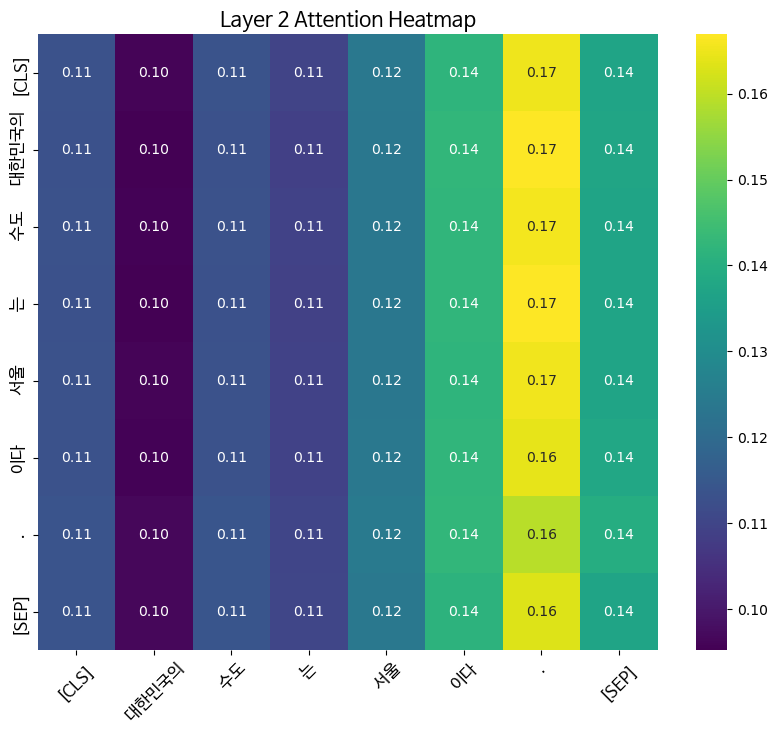

In [30]:
# --- 테스트 실행 ---
print("\n" + "="*50)
print(" MLM (Fill-in-the-blank) Test ".center(50, "="))
print("="*50)
test_mlm(model, vocab, "대한민국의 수도는 [MASK]이다.")
test_mlm(model, vocab, "오늘 점심으로 [MASK]을 먹고 싶다.")

print("\n" + "="*50)
print(" NSP (Next Sentence Prediction) Test ".center(50, "="))
print("="*50)
test_nsp(model, vocab, "오늘 날씨가 정말 좋네요.", "공원에 산책하러 가야겠어요.")
test_nsp(model, vocab, "오늘 날씨가 정말 좋네요.", "저녁에는 짜장면을 먹어야지.")

print("\n" + "="*50)
print(" Attention Visualization ".center(50, "="))
print("="*50)
visualize_attention(model, vocab, "대한민국의 수도는 서울이다.")